In [91]:
import numpy as np
import pandas as pd
import requests
import zipfile
import io

In [109]:
class RegularizedSVD:
    def __init__(self, n_users, n_items, n_factors, lr, reg, max_epochs):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.max_epochs = max_epochs
        
        self.user_factors = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
    
    def train(self, dataset):
        for epoch in range(self.max_epochs):
            np.random.shuffle(dataset)
            self.update(dataset)
            self.objective(dataset)

    def update(self, dataset):
        for (u, i, r) in dataset:
            pred = self.predict_single(u - 1, i - 1)  
            e = r - pred
            user_factors_u = self.user_factors[u - 1]
            item_factors_i = self.item_factors[i - 1]
            
            self.user_factors[u - 1] += self.lr * (e * item_factors_i - self.reg * user_factors_u)
            self.item_factors[i - 1] += self.lr * (e * user_factors_u - self.reg * item_factors_i)
    
    def objective(self, dataset):
        total = 0
        for (u, i, r) in dataset:
            pred = self.predict_single(u - 1, i - 1)  
            e = r - pred
            total += e**2
            total += self.reg * (np.linalg.norm(self.user_factors[u - 1])**2 + np.linalg.norm(self.item_factors[i - 1])**2)
        return total

    def predict_single(self, u, i):
        pred = np.dot(self.user_factors[u], self.item_factors[i])
        return pred

In [93]:
# URL direto para o arquivo ZIP
url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

# Baixar o arquivo ZIP
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Extrair e ler o arquivo 'u.data' em um DataFrame do pandas
with zip_file.open('ml-100k/u.data') as file:
    matriz_user_item = pd.read_csv(file, sep='\t', header=None, names=['User ID', 'Item ID', 'Rating', 'Timestamp'])

# Remover a coluna 'Timestamp'
matriz_user_item.drop('Timestamp', axis=1, inplace=True)

# Preencher valores nulos com 0 (se houver)
matriz_user_item.fillna(0, inplace=True)

# Determinar o número de usuários e itens únicos
n_users = matriz_user_item['User ID'].nunique()
n_items = matriz_user_item['Item ID'].nunique()

dataset = list(zip(matriz_user_item['User ID'].values, matriz_user_item['Item ID'].values, matriz_user_item['Rating'].values))

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

model = RegularizedSVD(n_users, n_items, n_factors=96, lr=0.001, reg=0.02, max_epochs=100)

model.train(train_data)

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score

def evaluate_rmse(model, test_data):
    predictions = []
    targets = []
    for (user, item, rating) in test_data:
        predicted_rating = model.predict_single(user - 1, item - 1)
        predictions.append(predicted_rating)
        targets.append(rating)
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    return rmse

def evaluate_mae(model, test_data):
    predictions = []
    targets = []
    for (user, item, rating) in test_data:
        predicted_rating = model.predict_single(user - 1, item - 1)
        predictions.append(predicted_rating)
        targets.append(rating)
    mae = mean_absolute_error(targets, predictions)
    return mae

def evaluate_classification_metrics(model, test_data, threshold=3.5):
    predictions = []
    targets = []
    for (user, item, rating) in test_data:
        predicted_rating = model.predict_single(user - 1, item - 1)
        predictions.append(1 if predicted_rating >= threshold else 0)
        targets.append(1 if rating >= threshold else 0)
    
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    return precision, recall, f1

test_rmse = evaluate_rmse(model, test_data)
print(f"RMSE no conjunto de teste: {test_rmse:.4f}")


test_mae = evaluate_mae(model, test_data)
print(f"MAE no conjunto de teste: {test_mae:.4f}")

test_precision, test_recall, test_f1 = evaluate_classification_metrics(model, test_data)

print(f"Precisão no conjunto de teste: {test_precision:.4f}")
print(f"Recall no conjunto de teste: {test_recall:.4f}")
print(f"F1-Score no conjunto de teste: {test_f1:.4f}")


RMSE no conjunto de teste: 0.9470
MAE no conjunto de teste: 0.7414
Precisão no conjunto de teste: 0.7466
Recall no conjunto de teste: 0.7218
F1-Score no conjunto de teste: 0.7340


In [96]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

learning_rates = [0.001, 0.0015, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
rmse_values = []

for lr in learning_rates:

    model = RegularizedSVD(n_users, n_items, n_factors=100, lr=lr, reg=0.002, max_epochs=5)
    model.train(train_data)  

    test_rmse = evaluate_rmse(model, test_data)

    rmse_values.append(test_rmse)
    print(f"Learning Rate: {lr}, Test RMSE: {test_rmse}")



Learning Rate: 0.001, Test RMSE: 3.6980004029427573
Learning Rate: 0.0015, Test RMSE: 3.6775489781030366
Learning Rate: 0.002, Test RMSE: 3.452903626282879
Learning Rate: 0.003, Test RMSE: 1.900191108480248
Learning Rate: 0.004, Test RMSE: 1.3760936498424967
Learning Rate: 0.005, Test RMSE: 1.176217322993063
Learning Rate: 0.006, Test RMSE: 1.0916311085489288
Learning Rate: 0.007, Test RMSE: 1.0504980977683567
Learning Rate: 0.008, Test RMSE: 1.0249104937656561
Learning Rate: 0.009, Test RMSE: 1.0078902725067609
Learning Rate: 0.01, Test RMSE: 0.9979014649934478


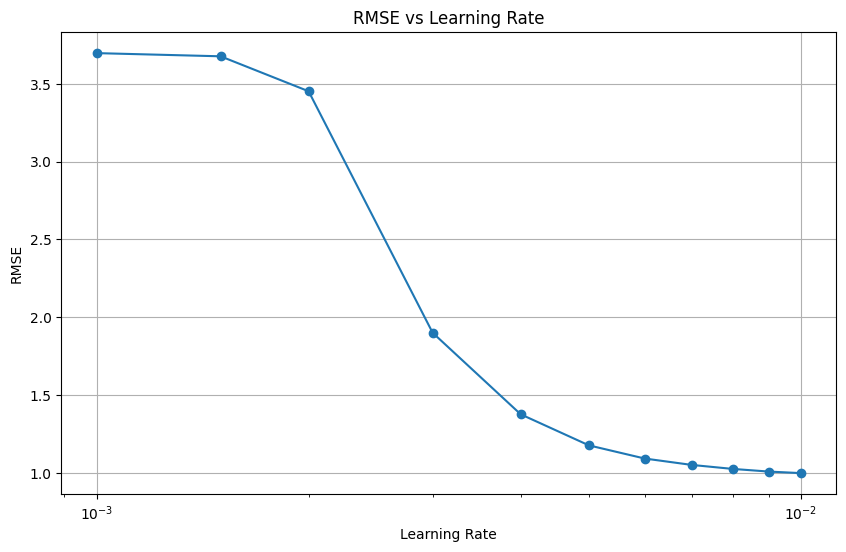

In [97]:
# Plot RMSE vs Learning Rate curve
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, rmse_values, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('RMSE vs Learning Rate')
plt.xscale('log')
plt.grid(True)
plt.show()